In [1]:
from symreg import Regressor
import pandas as pd
import numpy as np
import random
import traceback

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [ ]:
diff_data, duration_per = 600, 3 # 30 minutes
# diff_data, duration_per = 180, 3 # 15 minutes
# diff_data, duration_per = 120, 1.8 # 3.6 minutes
# diff_data, duration_per   = 30, 3 # instant

X, y = load_boston(return_X_y=True)
X /= X.mean()
y /= y.mean()
X, Xt, y, yt = train_test_split(X, y, test_size=0.4, random_state=0)

results = []

def time_left(diff_data):
    return f'{diff_data * duration_per / 60} minutes'

print(f'Will take {time_left(diff_data)}')

def eval_settings(**settings):
    r = Regressor(verbose=True, duration=duration_per, **settings)
    r.fit(X, y)
    
    y_out = r.predict(Xt, max_complexity=10)
    error = np.median((yt - y_out) ** 2)
    return {**settings, **{'error': error}}


for i in range(diff_data):
    random.seed(i)
    muts = {    
        'hoist_mutation_chance': random.random(),
        'prune_mutation_chance': random.random(),
        'grow_root_mutation_chance': random.random(),
        'grow_leaf_mutation_chance': random.random(),
    }
    point_mut_chance = random.random()
    
    totalmut = point_mut_chance + sum(v for v in muts.values())
    
    muts = {k: v/totalmut for k, v in muts.items()}
        
    try:
        args = {
            **muts,
            'simplify_chance': random.random(),
        }

        results.append(eval_settings(**args))
        print(results[-1])
        print('------------', time_left(diff_data - i-1), 'left')
    except ValueError as e:
        print('------------', 'Value Error for seed', i, ': ', args)
        traceback.print_exc()


In [ ]:
pd.DataFrame(results).sort_values('error').to_csv('metaopt.tsv', sep='\t', index=False)

In [2]:
resdf = pd.read_csv('metaopt.tsv', sep='\t').sort_values('error').dropna()
resdf['point_chance'] = 1-resdf[['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance']].sum(axis=1)

split = list(map(int, np.linspace(0, 100, 31)[1:]))
percs = [s/100 for s in split]
names = [f'{s}%' for s in split]
percentiles = resdf['error'].describe(percentiles=percs).loc[names]
print(names)
resdf['chunk'] = 0
for p in percentiles:
    resdf.loc[resdf['error'] > p, 'chunk'] += 1

final_res = pd.concat([resdf.groupby('chunk').mean(), resdf.groupby('chunk').count()['error']], axis=1)
final_res

['3%', '6%', '10%', '13%', '16%', '20%', '23%', '26%', '30%', '33%', '36%', '40%', '43%', '46%', '50%', '53%', '56%', '60%', '63%', '66%', '70%', '73%', '76%', '80%', '83%', '86%', '90%', '93%', '96%', '100%']


,hoist_mutation_chance,prune_mutation_chance,grow_root_mutation_chance,grow_leaf_mutation_chance,simplify_chance,error,point_chance,error
chunk,,,,,,,,
0,0.241217,0.159106,0.242941,0.160409,0.508267,0.011919,0.196327,18
1,0.247490,0.254896,0.151279,0.149418,0.557348,0.012971,0.196917,18
2,0.216759,0.224872,0.174319,0.205122,0.461865,0.013849,0.178929,24
3,0.238258,0.194086,0.201012,0.217717,0.414104,0.014776,0.148927,18
4,0.153245,0.208343,0.199992,0.208576,0.470323,0.015623,0.229844,18
5,0.167606,0.183448,0.209729,0.230416,0.505033,0.016174,0.208801,24
6,0.179716,0.218701,0.177271,0.173408,0.582373,0.016836,0.250903,18
7,0.202123,0.248325,0.155046,0.182638,0.482629,0.017390,0.211868,18
8,0.183436,0.220166,0.196162,0.178568,0.495028,0.017918,0.221668,24


We chose production parameters from the top row of above: 0.24 for hoist_mutation_chance and grow_root_mutation_chance, and 0.16 for prune_mutation_chance and grow_leaf_mutation_chance, and 0.5 for simplify_chance.

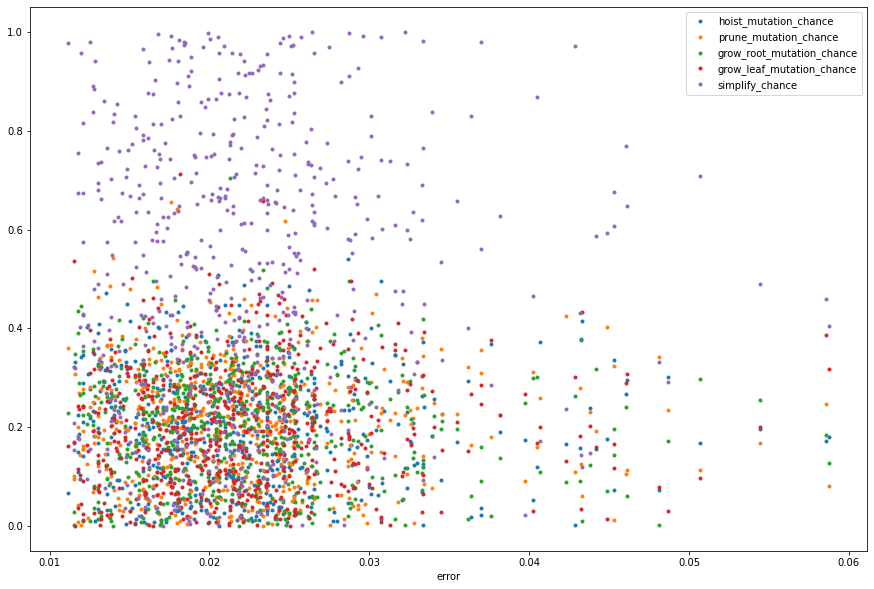

In [3]:
resdf.plot(y = ['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance', 'simplify_chance'], x='error', style='.', figsize=(15, 10))

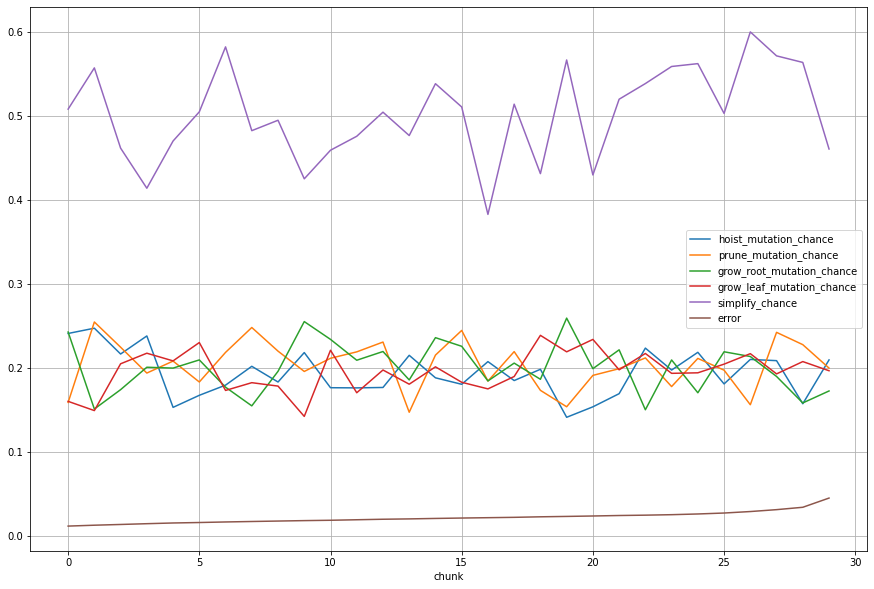

In [4]:
noerror = final_res.iloc[:, :-2]
noerror.plot(figsize=(15, 10), grid=True)
noerror /= noerror.mean()

In [5]:
final_res.iloc[:, :-1].corr('spearman')['error']

hoist_mutation_chance       -0.143048
prune_mutation_chance       -0.136819
grow_root_mutation_chance   -0.087875
grow_leaf_mutation_chance    0.271190
simplify_chance              0.337931
error                        1.000000
point_chance                 0.150167
Name: error, dtype: float64

We train another Regressor, to explain the error of the previous one. But there's still work to do for interpretability of the results.

In [6]:
r2 = Regressor(duration=10, verbose=True)
X = resdf.iloc[:,  :-2]
y = resdf.iloc[:, -2]
X['rand'] = np.random.random(np.shape(X.iloc[:, 0]))  # Add decoys as witnesses of overfitting
X['rand2'] = np.random.random(np.shape(X.iloc[:, 0]))
X /= X.mean()
y /= y.mean()

In [7]:
r2.fit(X, y)

Time left  : 8.96s
Best so far: (0.47011897044158923, 40) (error, complexity)
Time left  : 7.94s
Best so far: (0.4397810841085692, 49) (error, complexity)
Time left  : 6.93s
Best so far: (0.4125211973474621, 24) (error, complexity)
Time left  : 5.92s
Best so far: (0.3753538801083927, 64) (error, complexity)
Time left  : 4.91s
Best so far: (0.36424098831803325, 114) (error, complexity)
Time left  : 3.87s
Best so far: (0.3524393979251252, 112) (error, complexity)
Time left  : 2.82s
Best so far: (0.34829054702823226, 128) (error, complexity)
Time left  : 1.78s
Best so far: (0.34525688806626903, 136) (error, complexity)
Time left  : 0.76s
Best so far: (0.3429454012096675, 132) (error, complexity)
Complete. {'generations': 299, 'stagnated_generations': 1, 'duration': 10.15258264541626}


In [8]:
"""
[{'error': 0.0028049765715300722,
  'complexity': 1,
  'program': Program('0.014426645859910924', 3)},
"""

r2.results()

[{'error': 0.5510451848080834, 'complexity': 1, 'program': Program('1.0', 8)},
 {'error': 0.5444729397068288,
  'complexity': 3,
  'program': Program('pow 0.9083746525400235 $hoist_mutation_chance', 8)},
 {'error': 0.5333010013733164,
  'complexity': 5,
  'program': Program('pow pow 0.9083746525400235 $grow_leaf_mutation_chance $hoist_mutation_chance', 8)},
 {'error': 0.517520765174797,
  'complexity': 7,
  'program': Program('pow pow pow 0.8325022355197248 $grow_leaf_mutation_chance $prune_mutation_chance $hoist_mutation_chance', 8)},
 {'error': 0.49785170626311726,
  'complexity': 9,
  'program': Program('add pow pow pow 0.7875415086788184 $grow_leaf_mutation_chance $prune_mutation_chance $hoist_mutation_chance 0.08901267653587104', 8)},
 {'error': 0.46428813482467945,
  'complexity': 11,
  'program': Program('pow add pow pow pow 0.8325022355197248 $grow_leaf_mutation_chance $prune_mutation_chance $hoist_mutation_chance 0.08901267653587104 3.3358117337265027', 8)},
 {'error': 0.40091

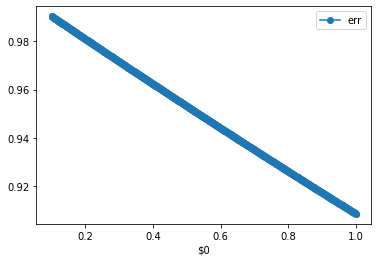

In [10]:
X = pd.DataFrame({'$0': np.linspace(0, 1, 1001)})
from symreg.ga import Program
p = Program(
    'pow 0.9083746525400235 $hoist_mutation_chance'
    .replace('$hoist_mutation_chance', '$0')
)
X['err'] = p.eval([X['$0']])
X[100:].plot(x='$0', y='err', marker='o')